# United Nations Financial Aid Report

Ian Kollipara

CS 392 Seminar in Data Science

2022.02.16

## Introduction

This report details what countries need financial aid, based on specific metrics. The methods used in this document are K-Means Clustering and Agglomerative-Heirarchical Clustering. Countries shown here need aid, but the type of aid needs further analysis. This will merely shrink the pool and acts as a filter more than anything.

## Data Exploration

### Introduction and Preliminary Data Conversion

This dataset contains social-economic data from 167 countries around the globe. The dataset is dated roughly to 2009 through comparison with datasets from that time in connection to GDPP. The GDPP is represented in US Dollars ($) for currency.

Each column's description is detailed as:
1. **country**: The Name of the Country
2. **child_mort**: Death Rate for Children < 5 years per 1,000 live births
3. **exports**: Percent of the GDP per Capita (GDPP) for exports of goods and services
4. **health**: Perecent of the GDPP spent on healthcare.
5. **imports**: Percent of the GDPP for imports of goods and services
6. **income**: The net income per person
7. **inflation**: The annual growth rate of the GDPP
8. **life_expec**: Expected number of years a new born should live given current mortality patterns
9. **total_fer**: Expected number of children born per women given current fertility patterns
10. **gdpp**: GDP per Capita (GDP / population)

The GDPP shown here is the Nominal GDPP, as opposed to the PPP GDPP. As such, the name `gdpp` will be changed to `nominal gdpp`. Beyond that, the health, exports, and imports columns are all percentages based on that Nominal GDPP. As such, they are converted to their numerical values.

In [1]:
# I chose to use polars out of curiousity, and to learn about another library. I quite like it compared to pandas
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from scipy.stats import zscore
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
df = pl.read_csv("countries.csv")

In [3]:
df

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
str,f64,f64,f64,f64,i64,f64,f64,f64,i64
"""Afghanistan""",90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
"""Albania""",16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
"""Algeria""",27.3,38.4,4.17,31.4,12900,16.1,76.5,2.89,4460
"""Angola""",119.0,62.3,2.85,42.9,5900,22.4,60.1,6.16,3530
"""Antigua and Barbuda""",10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
"""Argentina""",14.5,18.9,8.1,16.0,18700,20.9,75.8,2.37,10300
"""Armenia""",18.1,20.8,4.4,45.3,6700,7.77,73.3,1.69,3220
"""Australia""",4.8,19.8,8.73,20.9,41400,1.16,82.0,1.93,51900
"""Austria""",4.3,51.3,11.0,47.8,43200,0.873,80.5,1.44,46900


In [4]:
df = df.rename({"gdpp": "nominal gdpp"})

In [5]:
df = df.with_columns([
    ((pl.col("health") / 100) * pl.col("nominal gdpp")).alias("health"),
    ((pl.col("exports") / 100) * pl.col("nominal gdpp")).alias("exports"),
    ((pl.col("imports") / 100) * pl.col("nominal gdpp")).alias("imports"),
])

### Identifying Correlations

To better understand the dataset, and what columns have a relationship with another, identifying correlations is ideal. I use 2 different correlation coeffiecents:
1. Pearson

   I used this metric for linear correlation, as that's what its designed for. This is the default correlation in `pandas.DataFrame.corr()`.
    
   
2. Spearman Rank

    I used this metric for exponential distributions. This metric is designed for monotonic functions, which the exponential function is ([proof](https://www.bookofproofs.org/branches/exponential-function-is-strictly-monotonically-increasing-proof/))

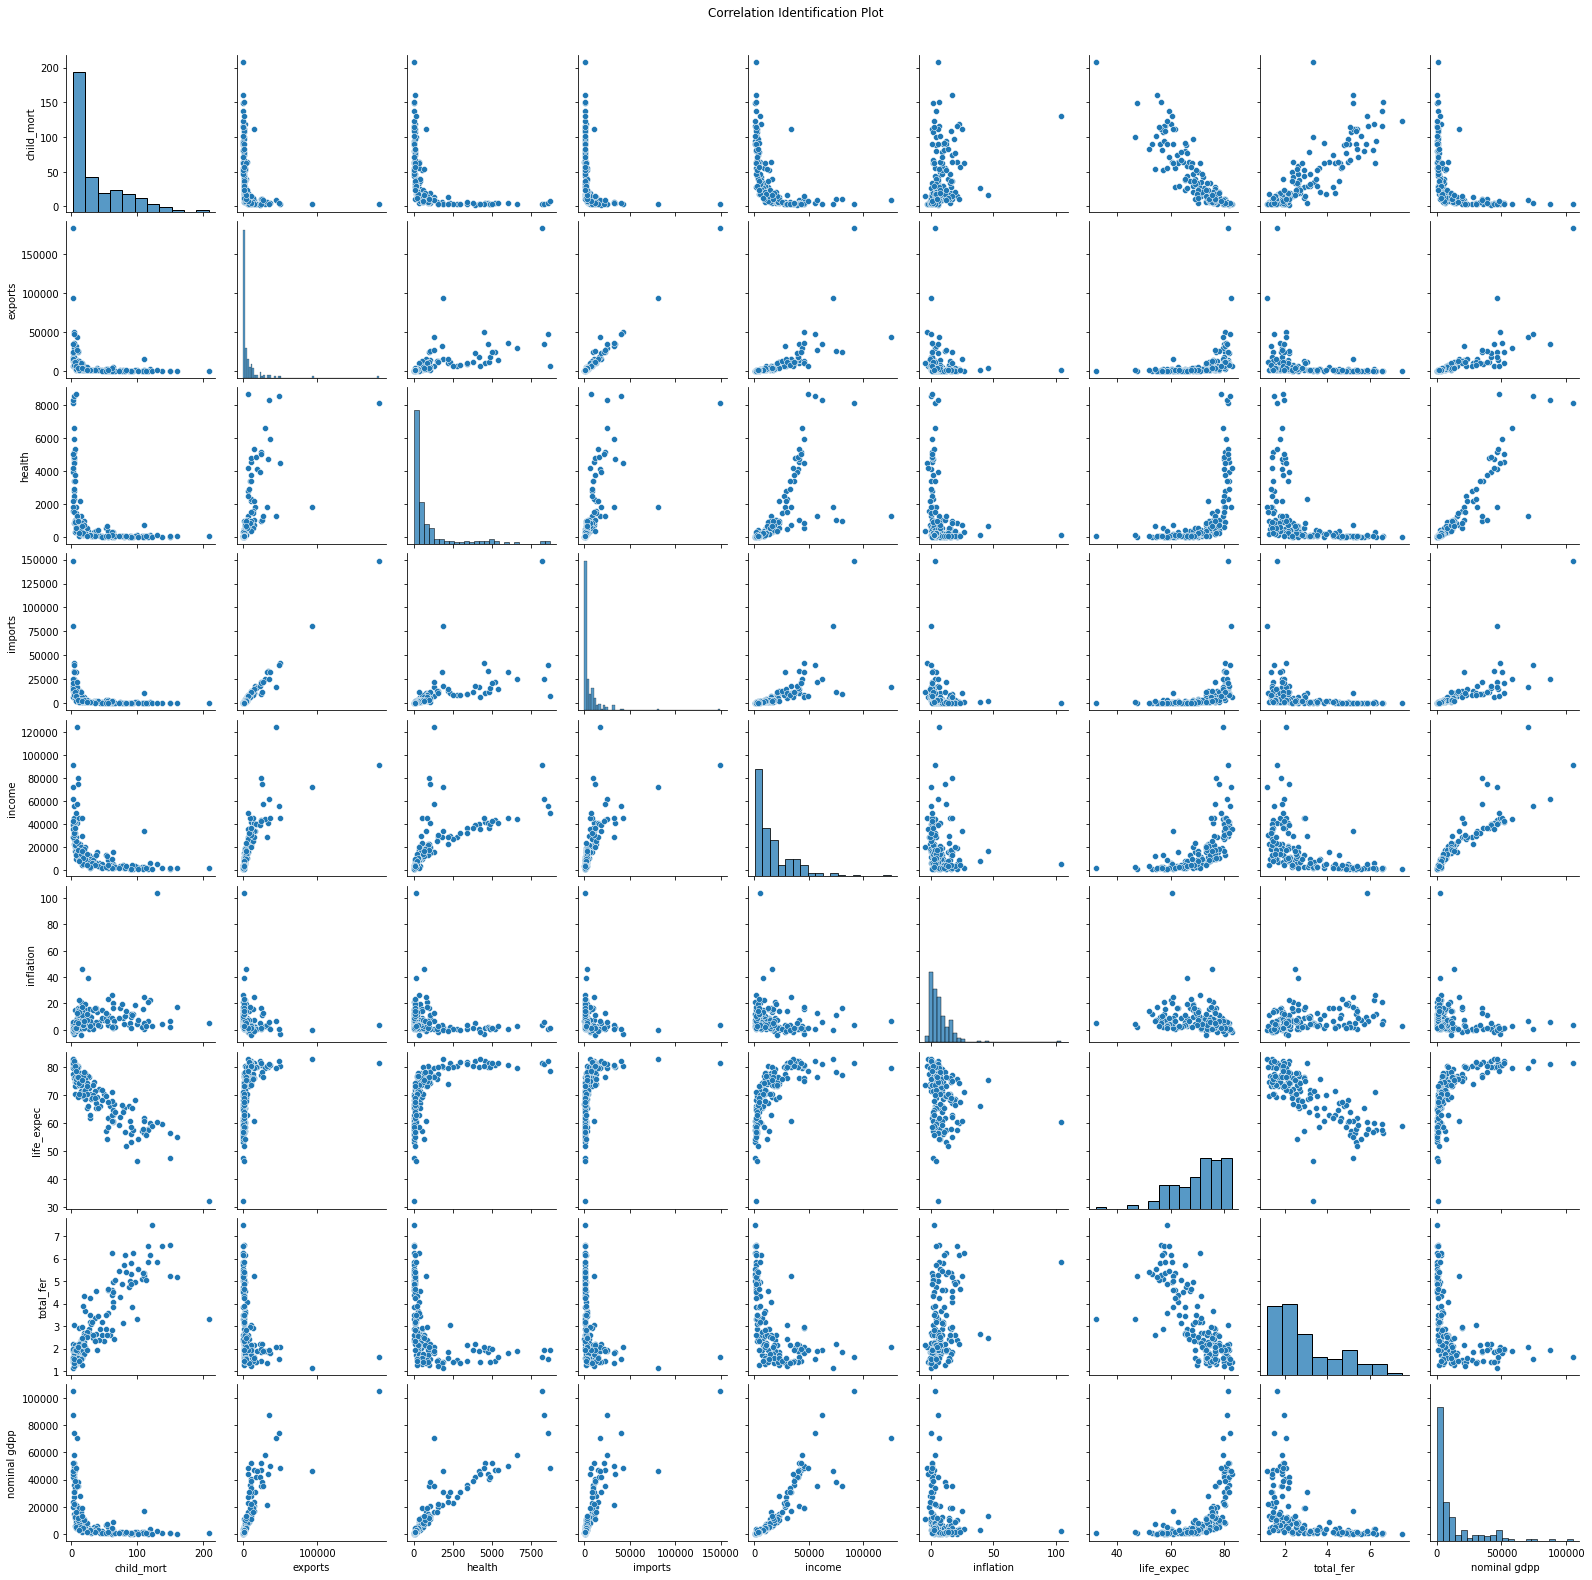

In [6]:
corr_plot = sns.pairplot(df.to_pandas())
corr_plot.fig.suptitle("Correlation Identification Plot")
corr_plot.fig.subplots_adjust(top=0.95)

From these scatterplots, a few correlations stand out:
1. Income holds a strong linear correlation with GDP per Capita. 
2. Life Expectancy holds the semblence of a linear correlation with Child Mortality Rate.
3. Imports holds a strong linear correlation with Exports.
4. Child Mortality also holds a strong linear correlation with Total Fertility Rate.
5. Life Expectancy holds an exponential correlation with GDP per Capita.
6. GDP per Capita also holds an exponential correlation with Child Mortality Rate.

Another correlation I wanted a closer look at was Income vs. Inflation. If we zoom in on that graph, we can see there's a few outliers that could effect the distribution of points, or the visible correlation. If we cut those out we get this graph.

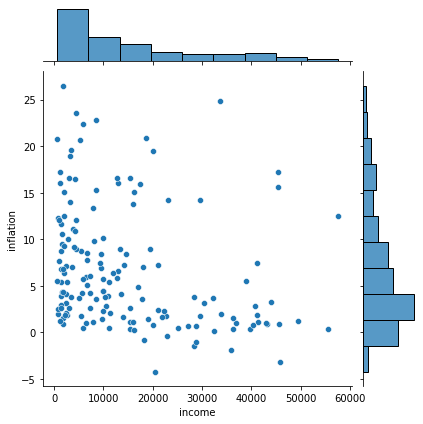

In [7]:
sns.jointplot(x="income", y="inflation", data=df.filter(
        (pl.col("inflation") < 30) &
        (pl.col("income") < 60_000))
        .to_pandas()
    )

As visible, there is no direct correlation. Potentially an exponential distribution, but there's too much noise to say for sure. As such, I did not calculate its correlation.

Looking at the correlations, we can see that many have values close to -1 or 1. These indicate strong correlation, and a chance to explore for causality. My fiancé -  a biology major - revealed that child mortality is heavily influenced by the wealth of the country. And this category in particular effects all health-related categories, like Life Expectancy and Total Fertility Rate. In particular, countries are prone to have more children - thereby increasing the natural fertility rate - when child mortality rate is high.

In [8]:
df[[
    pl.spearman_rank_corr("income", "child_mort").alias("income-child_mort"),
    pl.spearman_rank_corr("income", "life_expec").alias("income-life_expec"),
    pl.spearman_rank_corr("income", "total_fer").alias("income-total_fer"),
    pl.spearman_rank_corr("income", "nominal gdpp").alias("income-nominal gdpp"),
    pl.spearman_rank_corr("income", "imports").alias("income-imports"),
    pl.spearman_rank_corr("income", "health").alias("income-health"),
    pl.spearman_rank_corr("income", "exports").alias("income-exports"),
    pl.spearman_rank_corr("child_mort", "life_expec").alias("child_mort-life_expec"),
    pl.spearman_rank_corr("child_mort", "total_fer").alias("child_mort-total_fer"),
    pl.spearman_rank_corr("child_mort", "nominal gdpp").alias("child_mort-nominal gdpp"),
    pl.spearman_rank_corr("nominal gdpp", "life_expec").alias("nominal gdpp-life_expec")
]]

income-child_mort,income-life_expec,income-total_fer,income-nominal gdpp,income-imports,income-health,income-exports,child_mort-life_expec,child_mort-total_fer,child_mort-nominal gdpp,nominal gdpp-life_expec
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.867124,0.8422,-0.740725,0.978043,0.930947,0.937234,0.958485,-0.905132,0.8693,-0.876245,0.851579


Noting these correlations will be helpful in feature selection later on.

I chose not to do extensive outlier analysis, as to discount any countries from potential aid. I did, however, spend some time looking into the outliers - to see what they were and what they meant.

In [9]:
df.filter((pl.col("nominal gdpp") > 100_000) & (pl.col("imports") > 140_000))

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp
str,f64,f64,f64,f64,i64,f64,f64,f64,i64
"""Luxembourg""",2.8,183750.0,8158.5,149100.0,91700,3.62,81.3,1.63,105000


Luxembourg is noted as a "tax haven" (“List of Countries by GDP (Nominal) per Capita,” 2022). This type of country is one where taxation on foreign investors is quite low, thus a lot of money could be in the country.

In [10]:
df.filter((pl.col("life_expec") > 60) & (pl.col("inflation") > 100))

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp
str,f64,f64,f64,f64,i64,f64,f64,f64,i64
"""Nigeria""",130.0,589.49,118.131,405.42,5150,104.0,60.5,5.84,2330


Nigeria is interesting, as the country is completely apart from any other in terms of inflation vs. life expectency. From research, Nigeria has quite a prosperous private health sector, leading to growth in life expectancy. However, its high inflation comes from years of mismanaged rule and a dependence on natural resource exports.

In [11]:
df.filter((pl.col("child_mort") > 200) & (pl.col("total_fer") < 4))

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp
str,f64,f64,f64,f64,i64,f64,f64,f64,i64
"""Haiti""",208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662


Lastly, I found Haiti as an outlier in regards to fertility and child mortality. Much of this could be attributed to multiple natural disasters that have struck the country in recent years, rendering much of the population dead without much replacement happening.

These are all the outliers I found interesting to look at. In the case of Luxembourg, its safe to say it doesn't need anymore fanancial aid, but the other two might.

### Feature Selection

For the features, I chose 3 columns with the most correlation:
1. **Nominal GDPP**
2. **Income**
3. **Child Mortality Rate**

These 3 all have a good reflection on the standing of the country, and its citizenship.

In [12]:
X = df[["nominal gdpp", "income", "child_mort"]]
X

nominal gdpp,income,child_mort
i64,i64,f64
553,1610,90.2
4090,9930,16.6
4460,12900,27.3
3530,5900,119.0
12200,19100,10.3
10300,18700,14.5
3220,6700,18.1
51900,41400,4.8
46900,43200,4.3


To standardize these, and provide easier measurements for the algorithms to work with. The three standardization methods were:
1. Z-Score
2. Min-Max Scaling
3. PCA with Reduction to 2 columns

In the case of PCA, I chose the smallest amount of components that maintained at least 95% of the variation.

In [13]:
X_z = X[[pl.all().map(zscore)]]
X_scaled = pl.DataFrame._from_pandas(X.to_pandas().apply(minmax_scale))
X_pca = pl.DataFrame(PCA(2).fit_transform(StandardScaler().fit_transform(X.to_pandas())), ["pca1", "pca2"])

## Clustering

For all the clustering algorithms I chose to use the Euclidean distance, as in the case of cluster closeness, it makes sense to graph them together.

### KMeans Clustering

The first algorithm explored is based on clustering via a centroid. Ideally these centroids would match up well with different groups. Since many of my categories pertain well to economic standing, I'm expecting the clustering to reveal economic groups.

To figure out the correct feature set, I created an elbow graph of all 3 standardized metrics, and analyzed them to deduce an optimal $k=6$ and the optimal feature set being $X_z$.

Text(0.5, 1.0, 'Elbow Graph of KMeans Clusters vs. Inertia for X_pca')

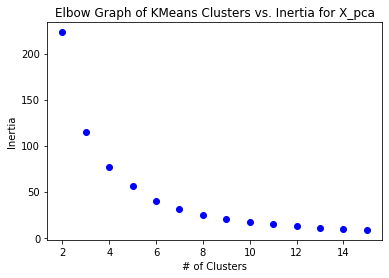

In [14]:
for k in range(2, 16):
    model = KMeans(k).fit(X_pca.to_pandas())
    plt.scatter(model.n_clusters, model.inertia_, c="blue")
plt.xlabel("# of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Graph of KMeans Clusters vs. Inertia for X_pca")

Text(0.5, 1.0, 'Elbow Graph of KMeans Clusters vs. Inertia for X_z')

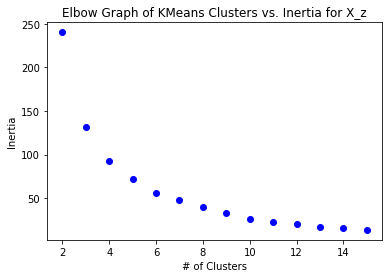

In [15]:
for k in range(2, 16):
    model = KMeans(k).fit(X_z.to_pandas())
    plt.scatter(model.n_clusters, model.inertia_, c="blue")
plt.xlabel("# of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Graph of KMeans Clusters vs. Inertia for X_z")

Text(0.5, 1.0, 'Elbow Graph of KMeans Clusters vs. Inertia for X_scaled')

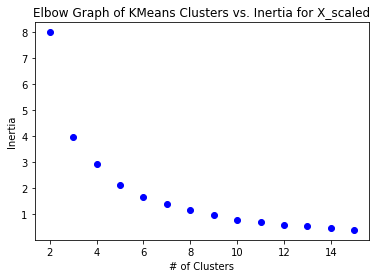

In [16]:
for k in range(2, 16):
    model = KMeans(k).fit(X_scaled.to_pandas())
    plt.scatter(model.n_clusters, model.inertia_, c="blue")
plt.xlabel("# of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Graph of KMeans Clusters vs. Inertia for X_scaled")

Using the aformention optimal $k=6$, we can visualize the graph as such.

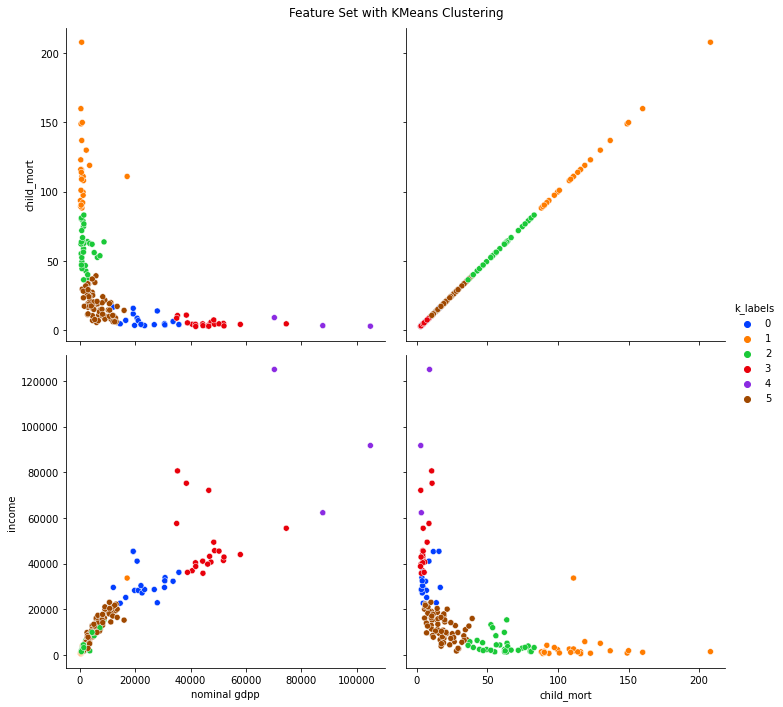

In [17]:
ideal_kmeans = KMeans(6).fit(X_z.to_pandas())
df["k_labels"] = ideal_kmeans.labels_
kplot = sns.PairGrid(data=df.to_pandas(), hue="k_labels", palette=sns.color_palette("bright", 6), x_vars=["nominal gdpp", "child_mort"], y_vars=["child_mort", "income"], height=5)
kplot.map(sns.scatterplot)
kplot.fig.suptitle("Feature Set with KMeans Clustering")
kplot.fig.subplots_adjust(top=0.95)
kplot.add_legend()

- **Blue(0)**: Below Average Countries
- **Orange(1)**: Strong Countries
- **Green(2)**: Above Average Countries
- **Red(3)**: Average Countries
- **Purple(4)**: Well Below Average Countries
- **Brown(5)**: Very Strong Countries

Based on these metrics, the countries to focus on would be those with Blue and Purple Colors. We can sort these based on each of our metrics in the feature set.

In [18]:
wcp = df.filter((pl.col("k_labels") == 4))

In [19]:
wcp.sort("child_mort", True).head(5)

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp,k_labels
str,f64,f64,f64,f64,i64,f64,f64,f64,i64,i32
"""Qatar""",9.0,43796.9,1272.43,16731.4,125000,6.98,79.5,2.07,70300,4
"""Norway""",3.2,34856.6,8323.44,25023.0,62300,5.95,81.0,1.95,87800,4
"""Luxembourg""",2.8,183750.0,8158.5,149100.0,91700,3.62,81.3,1.63,105000,4


In [20]:
wcp.sort("income").head(5)

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp,k_labels
str,f64,f64,f64,f64,i64,f64,f64,f64,i64,i32
"""Norway""",3.2,34856.6,8323.44,25023.0,62300,5.95,81.0,1.95,87800,4
"""Luxembourg""",2.8,183750.0,8158.5,149100.0,91700,3.62,81.3,1.63,105000,4
"""Qatar""",9.0,43796.9,1272.43,16731.4,125000,6.98,79.5,2.07,70300,4


In [21]:
wcp.sort("nominal gdpp").head(5)

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp,k_labels
str,f64,f64,f64,f64,i64,f64,f64,f64,i64,i32
"""Qatar""",9.0,43796.9,1272.43,16731.4,125000,6.98,79.5,2.07,70300,4
"""Norway""",3.2,34856.6,8323.44,25023.0,62300,5.95,81.0,1.95,87800,4
"""Luxembourg""",2.8,183750.0,8158.5,149100.0,91700,3.62,81.3,1.63,105000,4


Based on these metrics, the country that appears the most often is Democratic Republic of the Congo. Another common country is Central African Republic. Both of these country are facing civil wars and are quite underdeveloped. Another country that shows up often is Mozambique. Although its Child Mortality rate is not the lowest, its still quite high with 100+.

The sad fact about this list is that all of them, minus Haiti, are African Countries. It shows the state of the continent quite well. Based on this algorithm I would reccommend aid to DRC, CAR, and Mozambique, well as any extra funds to various countries in Africa. 

## Agglorative/Heirarchical Clustering

The next form of clustering used was Agglorative, or rather Heirarchical, clustering. I followed the same procedures as before, coming up with a $k=4$ and $X_{\text{scaled}}$ as my ideal Agglomerative Clustering values. 

An important difference is the use of dendrograms to determine the optimal $k$. These graphs showcase the combining of clusters, that is showing the heirarchy of them.

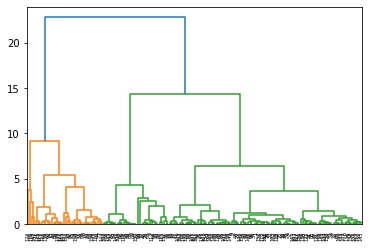

In [22]:
z_dendrogram = shc.dendrogram(shc.linkage(X_z.to_pandas(), "ward"))

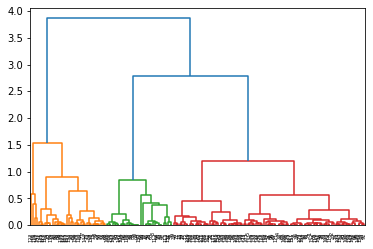

In [23]:
scaled_dendrogram = shc.dendrogram(shc.linkage(X_scaled.to_pandas(), "ward"))

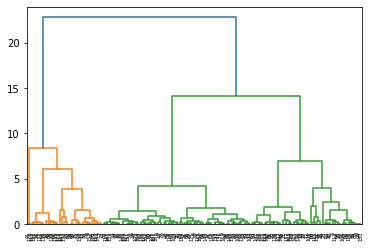

In [24]:
pca_dendrogram = shc.dendrogram(shc.linkage(X_pca.to_pandas(), "ward"))

From these dendrograms, it appears that $X_{\text{scaled}}$ has the most clusters at lower levels. If we then analyze its silhouette score, we can see the optimal $k=4$.

Text(0.5, 1.0, 'Distribution of Silhouette Score based on Number of Clusters')

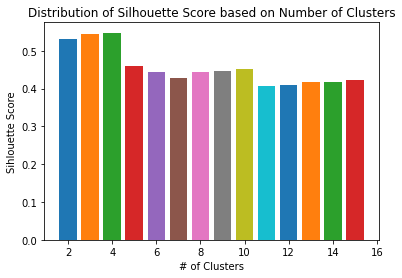

In [25]:
for k in range(2, 16):
    model = AgglomerativeClustering(k).fit(X_scaled.to_pandas())
    plt.bar(k, silhouette_score(X_scaled.to_pandas(), model.labels_))
plt.xlabel("# of Clusters")
plt.ylabel("Sihlouette Score")
plt.title("Distribution of Silhouette Score based on Number of Clusters")

As the graph shows the ideal $k=4$. From this we can generate the ideal model and see its clustering. Much of it should line up with the K-Means Clustering, as the metrics should cluster around economic status.

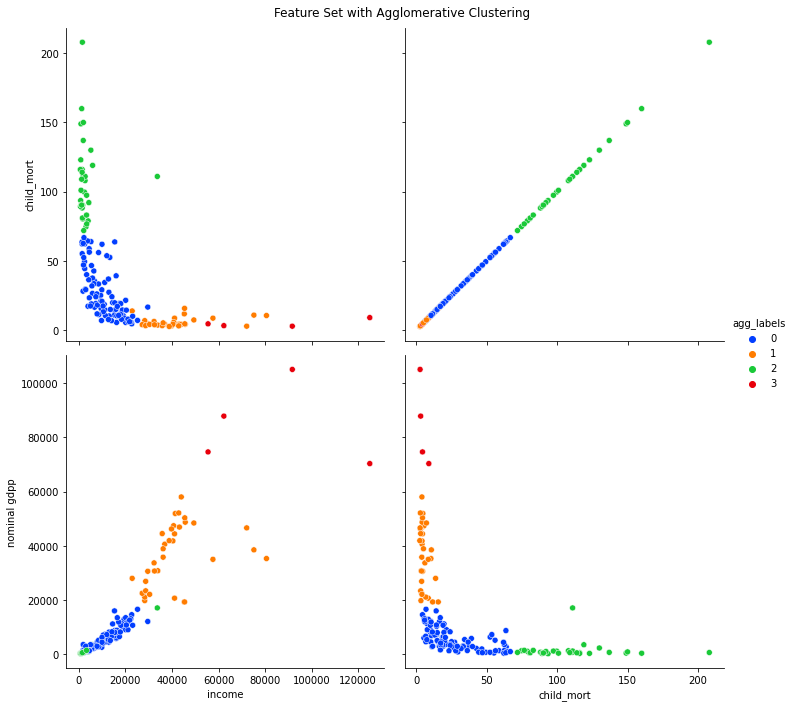

In [26]:
ideal_ag = AgglomerativeClustering(4).fit(X_scaled.to_pandas())

df["agg_labels"] = ideal_ag.labels_
aplot = sns.PairGrid(data=df.to_pandas(), hue="agg_labels", palette=sns.color_palette("bright", 4), x_vars=["income", "child_mort"], y_vars=["child_mort", "nominal gdpp"], height=5)
aplot.map(sns.scatterplot)
aplot.fig.suptitle("Feature Set with Agglomerative Clustering")
aplot.fig.subplots_adjust(top=0.95)
aplot.add_legend()

- **Blue(0)**: Below Average Countries
- **Orange(1)**: Average Countries
- **Green(2)**: Weak Countries
- **Red(3)**: Above Average Countries

Based on this, we want to look for countries in the Green Cluster. We can then view each sorted by one metric of the feature set, much like I did with K-Means.

In [27]:
wck = df.filter(pl.col("agg_labels") == 2)

In [28]:
wck.sort("income").head(5)

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp,k_labels,agg_labels
str,f64,f64,f64,f64,i64,f64,f64,f64,i64,i32,i64
"""Congo, Dem. Rep.""",116.0,137.274,26.4194,165.664,609,20.8,57.5,6.54,334,1,2
"""Liberia""",89.3,62.457,38.586,302.802,700,5.47,60.8,5.02,327,1,2
"""Burundi""",93.6,20.6052,26.796,90.552,764,12.3,57.7,6.26,231,1,2
"""Niger""",123.0,77.256,17.9568,170.868,814,2.55,58.8,7.49,348,1,2
"""Central African Republic""",149.0,52.628,17.7508,118.19,888,2.01,47.5,5.21,446,1,2


In [29]:
wck.sort("child_mort", True).head(5)

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp,k_labels,agg_labels
str,f64,f64,f64,f64,i64,f64,f64,f64,i64,i32,i64
"""Haiti""",208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,1,2
"""Sierra Leone""",160.0,67.032,52.269,137.655,1220,17.2,55.0,5.2,399,1,2
"""Chad""",150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,1,2
"""Central African Republic""",149.0,52.628,17.7508,118.19,888,2.01,47.5,5.21,446,1,2
"""Mali""",137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,1,2


In [30]:
wck.sort("nominal gdpp").head(5)

country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,nominal gdpp,k_labels,agg_labels
str,f64,f64,f64,f64,i64,f64,f64,f64,i64,i32,i64
"""Burundi""",93.6,20.6052,26.796,90.552,764,12.3,57.7,6.26,231,1,2
"""Liberia""",89.3,62.457,38.586,302.802,700,5.47,60.8,5.02,327,1,2
"""Congo, Dem. Rep.""",116.0,137.274,26.4194,165.664,609,20.8,57.5,6.54,334,1,2
"""Niger""",123.0,77.256,17.9568,170.868,814,2.55,58.8,7.49,348,1,2
"""Sierra Leone""",160.0,67.032,52.269,137.655,1220,17.2,55.0,5.2,399,1,2


From this, we again see many African countries just as before. The most common countries are Democratic Republic of the Congo, Central African Republic, and Niger. We've alread discussed DRC and CRA, but Niger is new. This is a western African country, with an extremely poor economy. The country is landlocked, making trade incredibly difficult. By providing ways for them to better utilize their natural resource of the Niger River, we can maybe help their country's economy improve.

![(“Niger,” 2022)](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Niger_%28orthographic_projection%29.svg/375px-Niger_%28orthographic_projection%29.svg.png)

## Conclusion

Based on all the above analysis, I recommend 3 countries in, and to a lesser extent the continent of, Africa.

### Central African Republic

![(“Central African Republic,” 2022)](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Location_Central_African_Republic_AU_Africa.svg/375px-Location_Central_African_Republic_AU_Africa.svg.png)

CAR is landlocked, with an ongoing civil that started over a decade ago in 2012. The country has faced severe strife, including numerous human rights abuses, "The civil war perpetuated the country's poor human rights record: it was characterized by widespread and increasing abuses by various participating armed groups, such as arbitrary imprisonment, torture, and restrictions on freedom of the press and freedom of movement" ("Central African Republic," 2022). 

This country is in need of major aid, much beyond financially. It first needs some stability before we can truly help it. However, if that were to occur, funding ways to capitalize on its massive natural resources could catapult this country to a powerhouse of the continent.

### Democratic Republic of the Congo
![(“Democratic Republic of the Congo,” 2022)](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Location_Democratic_Republic_of_the_Congo_AU_Africa.svg/375px-Location_Democratic_Republic_of_the_Congo_AU_Africa.svg.png)

DRC is another landlocked African country, located directly south of CAR it shares many of the same issues. DRC has been home to ongoing conflict on its eastern half for quite a long time. The large country, with the world's 11$^\text{th}$ in population. 
> "The Democratic Republic of the Congo is extremely rich in natural resources but has suffered from political instability, a lack of infrastructure, corruption, and centuries of both commercial and colonial extraction and exploitation with little widespread development. Besides the capital Kinshasa, the two next largest cities, Lubumbashi and Mbuji-Mayi, are both mining communities. The DRC's largest export is raw minerals, with China accepting over 50% of its exports in 2019. In 2019, DR Congo's level of human development was ranked 175th out of 189 countries by the Human Development Index. As of 2018, around 600,000 Congolese have fled to neighbouring countries from conflicts in the centre and east of the DRC. Two million children risk starvation, and the fighting has displaced 4.5 million people. ("Democratic Republic of the Congo," 2022)

Much of my concerns with immediately aiding the CAR are present here in the DRC. I would look for stability, then provide strong financial aid. With a large population, may resources, and a location that can breed strength, the DRC is a vital country for the success of the continent. But for that to be so, we must find that stability.

### Niger
![("Niger," 2022](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Niger_%28orthographic_projection%29.svg/375px-Niger_%28orthographic_projection%29.svg.png)

Niger is another landlocked country, but doesn't share the same abundance of resources that the previous two have. The biggest struggle is the Sahara, which covers most of the eastern half of the country. This limits the ability to grow food and thrive, and with the growth of desertification, it becomes even more dangerous. Niger also faces other issues, with low education rates and a rural community. The population is predominately Mulsim, making aid from the west potentially difficult. 

Out of all the countries, I believe Niger is in the most need. Its is relatively stable, but lacks in ways to build a strong populus. The need for education can be solved through funding. Funding can also lead to new ways of farming, or potentially reclaiming the desert. Niger is, by far, the country with the most immediate potential.

## Resources
Central African Republic. (2022). In Wikipedia. https://en.wikipedia.org/w/index.php?title=Central_African_Republic&oldid=1072059366

Democratic Republic of the Congo. (2022). In Wikipedia. https://en.wikipedia.org/w/index.php?title=Democratic_Republic_of_the_Congo&oldid=1072402110

Implementing Agglomerative Clustering using Sklearn. (2019, June 7). GeeksforGeeks. https://www.geeksforgeeks.org/implementing-agglomerative-clustering-using-sklearn/

List of countries by GDP (nominal) per capita. (2022). In Wikipedia. https://en.wikipedia.org/w/index.php?title=List_of_countries_by_GDP_(nominal)_per_capita&oldid=1071754855

Niger. (2022). In Wikipedia. https://en.wikipedia.org/w/index.php?title=Niger&oldid=1070263403